In [11]:
# This is to ignore the warnings when running the code
import warnings 
warnings.filterwarnings('ignore')

In [12]:
# Importing libraries
import trueq as tq
import trueq.simulation as tqs
import trueq.math as tqm
from trueq import Gate
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [13]:
# Classifying gates
easy_gates = [Gate.x, Gate.y, Gate.z, Gate.id, Gate.s]
one_qubit_hard_gates = [Gate.h, Gate.t]
multi_qubit_hard_gates = [Gate.cx, Gate.cz]
hard_gates = one_qubit_hard_gates + multi_qubit_hard_gates

# Adding noise to hard gates
match_noisy_gates = tqs.GateMatch(hard_gates)

In [14]:
def random_tuple(n): # Returns a random tumple, will be used to generate random hard multi-qubit gates
    return tuple(random.sample(range(n), 2))

In [15]:
def random_cycle(n): # Generates one random cycle of easy and hard gates, the round of hard gates only contains 1 hard gate

    cycle = []
    easy_gate_cycle = {}

    for i in range(n):
        easy_gate_cycle[i] = random.choice(easy_gates)

    random_hard_gate = random.choice(hard_gates)

    if random_hard_gate in multi_qubit_hard_gates:
        hard_gate_cycle = {random_tuple(n): random_hard_gate}
        
    else:
        hard_gate_cycle = {random.randint(0,n-1): random_hard_gate}
    
    cycle.append(easy_gate_cycle)
    cycle.append(hard_gate_cycle)

    return cycle

In [16]:
def random_rc_circuit(n_qubits, n_cycles): # Generates a random circuits with number of qubits and cycles as parameters

    final_circuit = []

    for i in range(n_cycles):
        final_circuit.extend(random_cycle(n_qubits))

    last_easy_gate_cycle = {}

    for i in range(n_qubits):
        last_easy_gate_cycle[i] = random.choice(easy_gates)

    final_circuit.append(last_easy_gate_cycle)
    circuit = tq.Circuit(final_circuit)
    circuit.measure_all()
    
    return circuit
    

In [17]:
# Example of random_rc_circuits
random_rc_circuit(5,8).draw()

DisplayWrapper(<svg xmlns="http://w...)

In [18]:
def RC(n_qubits, n_cycles, n_compilations, noise): # Runs RC, prints TVD with and without RC, plots the counts, and returns the original circuit

    circuit = random_rc_circuit(n_qubits, n_cycles)
    sim = tq.Simulator()
    ideal_result = sim.sample(circuit, n_shots=np.inf)
    noisy_sim = tq.Simulator().add_overrotation(single_sys= noise, multi_sys= noise, match=match_noisy_gates)
    noisy_result = noisy_sim.sample(circuit, n_shots=np.inf)
    rc_circuits = tq.randomly_compile(circuit, n_compilations=n_compilations)
    noisy_sim.run(rc_circuits, n_shots=np.inf)
    rc_result = rc_circuits.sum_results()

    bare_tvd = noisy_result.tvd(ideal_result)
    rc_tvd = rc_result.normalized().tvd(ideal_result)

    print("Noisy simulation without RC: {:.4f}".format(bare_tvd[0]))
    print("Noisy simulation with RC: {:.4f}".format(rc_tvd[0]))

    tq.visualization.plot_results(
    ideal_result,
    noisy_result,
    rc_result,
    labels=["Ideal Outcome", "Without RC", "With RC"],
    )  
    
    return circuit


Noisy simulation without RC: 0.0914
Noisy simulation with RC: 0.0496


DisplayWrapper(<svg xmlns="http://w...)

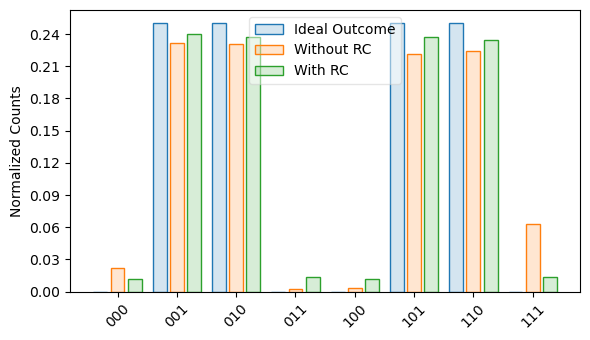

In [19]:
# Example of RC function running
RC(n_qubits= 3, n_cycles= 10, n_compilations=30, noise=0.1).draw()

In [20]:
def TVD_RC(n_qubits, n_cycles, n_compilations, noise): # Returns TVD of a random circuit with and without RC
    
    circuit = random_rc_circuit(n_qubits, n_cycles)
    sim = tq.Simulator()
    ideal_result = sim.sample(circuit, n_shots=np.inf)
    noisy_sim = tq.Simulator().add_overrotation(single_sys= noise, multi_sys= noise, match=match_noisy_gates)
    noisy_result = noisy_sim.sample(circuit, n_shots=np.inf)
    rc_circuits = tq.randomly_compile(circuit, n_compilations=n_compilations)
    noisy_sim.run(rc_circuits, n_shots=np.inf)
    rc_result = rc_circuits.sum_results()

    bare_tvd = noisy_result.tvd(ideal_result)
    rc_tvd = rc_result.normalized().tvd(ideal_result)

    if rc_tvd[0] != np.inf and bare_tvd[0] != np.inf:
        return rc_tvd[0], bare_tvd[0]
    
    else:
        while True:
            tvd = TVD_RC(n_qubits, n_cycles, n_compilations, noise)
            if tvd != np.inf:
                return tvd



In [21]:
# Example of TVD_RC
TVD_RC(n_qubits= 3, n_cycles= 10, n_compilations=30, noise=0.1)

(0.01386732038304006, 0.04774575140626329)

In [22]:
def RC_dataset(n_qubits, n_compilations, n_cycles_list, noise_list, n_circuits): # Generates a dataset for TVDs with and without RC for different number of cycles and noise levels
    data = []
    for cycles in n_cycles_list:
        for noise in noise_list:
            for _ in range(n_circuits):
                rc_tvd, bare_tvd = TVD_RC(n_qubits=3, n_compilations= 30, n_cycles=cycles, noise=noise)
                rc_dict = {"cycles": cycles, "noise": noise, "RC": "With RC", "TVD":rc_tvd}
                bare_dict = {"cycles": cycles, "noise": noise, "RC": "Without RC", "TVD":bare_tvd}
                data.append(rc_dict)
                data.append(bare_dict)
                
    return pd.DataFrame(data=data)

In [24]:
# Example of RC_dataset
n_cycles = [5,10,15,20,25,30]
noise_vals = [0.1, 0.2]

df = RC_dataset(n_qubits=3, n_compilations=30, n_cycles_list= n_cycles, noise_list= noise_vals, n_circuits=40)
df

,cycles,noise,RC,TVD
0,5,0.1,With RC,0.024172
1,5,0.1,Without RC,0.012236
2,5,0.1,With RC,0.000000
3,5,0.1,Without RC,0.048345
4,5,0.1,With RC,0.012236
...,...,...,...,...
955,30,0.2,Without RC,0.280113
956,30,0.2,With RC,0.367149
957,30,0.2,Without RC,0.261498
958,30,0.2,With RC,0.027719


In [25]:
# Example: generating boxplots of TVDs for noise = 0.1
noise_0 = df.loc[df['noise']== 0.1]
noise_0

,cycles,noise,RC,TVD
0,5,0.1,With RC,0.024172
1,5,0.1,Without RC,0.012236
2,5,0.1,With RC,0.000000
3,5,0.1,Without RC,0.048345
4,5,0.1,With RC,0.012236
...,...,...,...,...
875,30,0.1,Without RC,0.106229
876,30,0.1,With RC,0.049789
877,30,0.1,Without RC,0.230599
878,30,0.1,With RC,0.068965


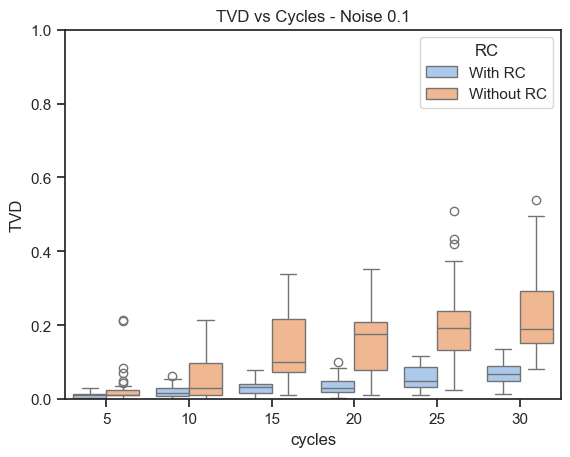

In [26]:
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(data=noise_0, x = "cycles", y= "TVD", hue= 'RC').set_title("TVD vs Cycles - Noise 0.1")
plt.ylim(0,1)
plt.show()